## **Loading Data**
---

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

In [ ]:
# define input features
index = ["ProgId", "InputId", "ConfigId"]

mem_features = ["Mem_Latency", "L1_Sets", "L1_Latency",
                "L2_Sets","L2_Latency",]

program_features = ["L1_Hits_1Thread", "L1_Misses_1Thread", "L2_Hits_1Thread", "L3_Misses_1Thread", # "L2_Misses_1Thread", "L3_Hits_1Thread",
                    "Instructions_1Thread", "Instructions_2Thread", "BranchPredictionAccuracy_1Thread", "pThreads"]

input_features = mem_features + program_features

target = "SpeedUp"


In [ ]:
# load data
data_path = "https://raw.githubusercontent.com/s-rishu/performance-predictor/main/sim_data/stats.csv"
data = pd.read_csv(data_path)

# check data types
print(data.dtypes)

ProgId                                  int64
InputId                                 int64
pThreads                                int64
ConfigId                                int64
Mem_Hits                              float64
Mem_Misses                            float64
Mem_Latency                             int64
L1_Sets                                 int64
L1_Latency                              int64
L1_Hits                               float64
L1_Misses                             float64
L2_Sets                                 int64
L2_Latency                              int64
L2_Hits                               float64
L2_Misses                               int64
L3_Hits                               float64
L3_Misses                             float64
Instructions                            int64
InstructionsPerSecond                   int64
SimTime                               float64
Cycles                                  int64
CyclesPerSecond                   

In [ ]:
# grouped_df = data.groupby(index)
# gb = grouped_df.groups

# for key, item in grouped_df:
#     print("For key {}:\n".format(key), grouped_df.get_group(key)['pThreads'], "\n\n")

#clean data to remove groups that don't have data for 2 threads

data = data[(data['ProgId']!=12) & (data['InputId']!=5)]
data = data[(data['ProgId']!=13) & (data['InputId']!=3)]

## **Calculate SpeedUp**
---

In [ ]:
# calculate speedup for each row
data["SpeedUp"] = data.groupby(index)['SimTime'].transform(lambda x: x / x[data['pThreads'] == 1].values[0])

data["L1_Hits_1Thread"] = data.groupby(index)['L1_Hits'].transform(lambda x: x[data['pThreads'] == 1].values[0])
data["L1_Misses_1Thread"] = data.groupby(index)['L1_Misses'].transform(lambda x: x[data['pThreads'] == 1].values[0])

data["L2_Hits_1Thread"] = data.groupby(index)['L2_Hits'].transform(lambda x: x[data['pThreads'] == 1].values[0])
data["L2_Misses_1Thread"] = data.groupby(index)['L2_Misses'].transform(lambda x: x[data['pThreads'] == 1].values[0])

data["L3_Hits_1Thread"] = data.groupby(index)['L3_Hits'].transform(lambda x: x[data['pThreads'] == 1].values[0])
data["L3_Misses_1Thread"] = data.groupby(index)['L3_Misses'].transform(lambda x: x[data['pThreads'] == 1].values[0])


data["Instructions_1Thread"] = data.groupby(index)['Instructions'].transform(lambda x: x[data['pThreads'] == 1].values[0])
data["Instructions_2Thread"] = data.groupby(index)['Instructions'].transform(lambda x: x[data['pThreads'] == 2].values[0])

data["BranchPredictionAccuracy_1Thread"] = data.groupby(index)['BranchPredictionAccuracy'].transform(lambda x: x[data['pThreads'] == 1].values[0])

# drop columns that are no longer needed
data = data[input_features + [target]]
print(data.head(10))

     Mem_Latency  L1_Sets  L1_Latency  L2_Sets  L2_Latency  L1_Hits_1Thread  \
128          200       64           3     1024          18        1095251.0   
129          200      128           3     1024          25        1095370.0   
130          250       64           3     2048          25        1095253.0   
131          250      128           4     1024          25        1070481.0   
132          300       64           4     2048          25        1070392.0   
133          200       64           3     1024          18        1095251.0   
134          200      128           3     1024          25        1095370.0   
135          250       64           3     2048          25        1095253.0   
136          250      128           4     1024          25        1070481.0   
137          300       64           4     2048          25        1070392.0   

     L1_Misses_1Thread  L2_Hits_1Thread  L3_Misses_1Thread  \
128            11911.0           8821.0            11748.0   
129   

## **Feature Selection**
---

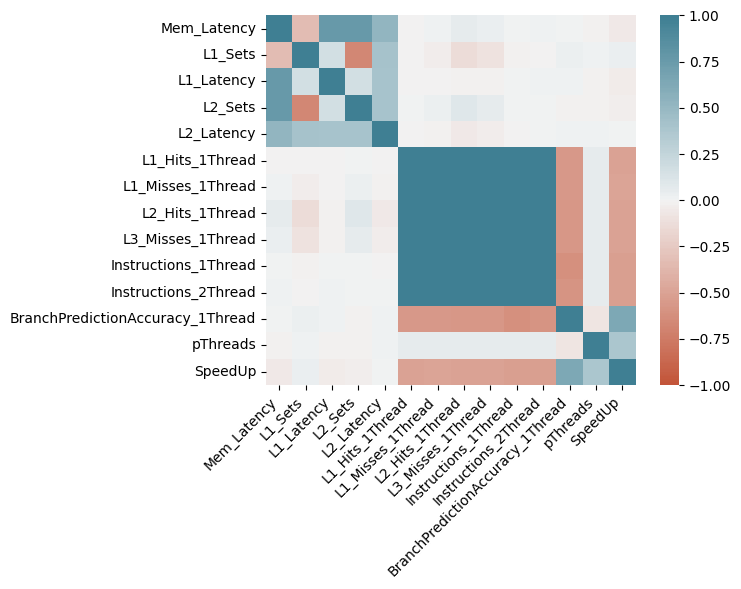

In [ ]:
#exploring useful features through correlation matrix
corr = data.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
# TODO: remove features if needed
# print("Final modelling attributes along with target variable:\n\n")
# print(data.dtypes)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error


## **Splitting the dataset for training and testing**
---

In [ ]:
#splitting into training and test sets
from sklearn.model_selection import train_test_split
#shuffle data
data = data.sample(frac = 1)
Y = data[target]
X = data.drop(columns=[target])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.20, random_state=39)

## **Exploring Linear Regression**
---

In [31]:
# train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

LinearRegression()

In [32]:
# test the linear regression model
Y_pred = lr_model.predict(X_test)

# get maximum residual error
print("Maximum Residual Error: {}".format(max_error(Y_test, Y_pred)))

# get mean squared error
print("Mean Squared Error: {}".format(mean_squared_error(Y_test, Y_pred)))

# get mean absolute error
print("Mean Absolute Error: {}".format(mean_absolute_error(Y_test, Y_pred)))

#check accuracy percentage with absolute prediction error <0.5
absolute_error = abs(Y_test - Y_pred)
within_range_count = sum(absolute_error <= 0.5)
percentage_within_range = (within_range_count / len(Y_test)) * 100

print(f"Percentage of Y_pred values with prediction error within +0.5 to -0.5: {percentage_within_range:.2f}%")


Maximum Residual Error: 2.393863250254128
Mean Squared Error: 1.5949787026321356
Mean Absolute Error: 1.0853047793168027
Percentage of Y_pred values with prediction error within +0.5 to -0.5: 29.17%


In [33]:
# save the model to disk
filename = 'lr_model.sav'
pickle.dump(lr_model, open(filename, 'wb'))

## **Exploring Decision Tree Regression**
---

In [ ]:
# train the decesion tree regression model
dtr_model = DecisionTreeRegressor()
dtr_model.fit(X_train, Y_train)

DecisionTreeRegressor()

In [ ]:
# test the decesion tree regression model
Y_pred = dtr_model.predict(X_test)

# get maximum residual error
print("Maximum Residual Error: {}".format(max_error(Y_test, Y_pred)))

# get mean squared error
print("Mean Squared Error: {}".format(mean_squared_error(Y_test, Y_pred)))

# get mean absolute error
print("Mean Absolute Error: {}".format(mean_absolute_error(Y_test, Y_pred)))

#check accuracy percentage with absolute prediction error <0.5
absolute_error = abs(Y_test - Y_pred)
within_range_count = sum(absolute_error <= 0.5)
percentage_within_range = (within_range_count / len(Y_test)) * 100

print(f"Percentage of Y_pred values with prediction error within +0.5 to -0.5: {percentage_within_range:.2f}%")

Maximum Residual Error: 0.6830592193528355
Mean Squared Error: 0.03615064353420958
Mean Absolute Error: 0.08241594721892241
Percentage of Y_pred values with prediction error within +0.5 to -0.5: 91.67%


In [ ]:
print(dtr_model.feature_importances_)
print(dtr_model.feature_names_in_)

[1.16637796e-03 2.03319079e-05 8.79645859e-04 2.20404189e-07
 1.30158118e-06 7.55365401e-04 4.69564413e-03 2.63011269e-03
 5.20525581e-01 9.40704909e-03 1.54374053e-04 3.67827518e-06
 4.59760317e-01]
['Mem_Latency' 'L1_Sets' 'L1_Latency' 'L2_Sets' 'L2_Latency'
 'L1_Hits_1Thread' 'L1_Misses_1Thread' 'L2_Hits_1Thread'
 'L3_Misses_1Thread' 'Instructions_1Thread' 'Instructions_2Thread'
 'BranchPredictionAccuracy_1Thread' 'pThreads']


In [34]:
# save the model to disk
filename = 'dtr_model.sav'
pickle.dump(dtr_model, open(filename, 'wb'))